

**Практика 7: Создание и использование генеративных противоречивых примеров (GAN- based Adversarial Examples)**

**Выполнил: Очередько Антон Николаевич ББМО-01-23**


Шаг 1: Создание простой GAN для генерации противоречивых примеров

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Загрузка и подготовка данных MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0  # Нормализация изображений

# Добавление канала для работы с CNN
x_train = np.expand_dims(x_train, axis=-1)

# Определение генератора
def create_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Определение дискриминатора
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Инициализация генератора и дискриминатора
generator_model = create_generator()
discriminator_model = create_discriminator()

# Компиляция дискриминатора
discriminator_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Создание модели GAN
input_noise = layers.Input(shape=(100,))
generated_image = generator_model(input_noise)
discriminator_model.trainable = False
validity = discriminator_model(generated_image)
gan_model = tf.keras.Model(input_noise, validity)
gan_model.compile(optimizer='adam', loss='binary_crossentropy')

# Функция обучения GAN
def train_gan_model(generator_model, discriminator_model, gan_model, epochs=1000, batch_size=64):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Обучение дискриминатора на реальных и фальшивых изображениях
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]
        noise_input = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator_model.predict(noise_input)
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))
        real_loss = discriminator_model.train_on_batch(real_images, real_labels)
        fake_loss = discriminator_model.train_on_batch(fake_images, fake_labels)

        # Обучение генератора через GAN
        noise_input = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))
        generator_loss = gan_model.train_on_batch(noise_input, valid_labels)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} [D loss: {0.5 * np.add(real_loss, fake_loss)}] [G loss: {generator_loss}]")

# Обучение GAN модели
train_gan_model(generator_model, discriminator_model, gan_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 0 [D loss: [0.6685771 0.8359375]] [G loss: [array(0.66180557, dtype=float32), array(0.66180557, dtype=float32), array(0.890625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━

Шаг 2: Генерация противоречивых примеров с помощью GAN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


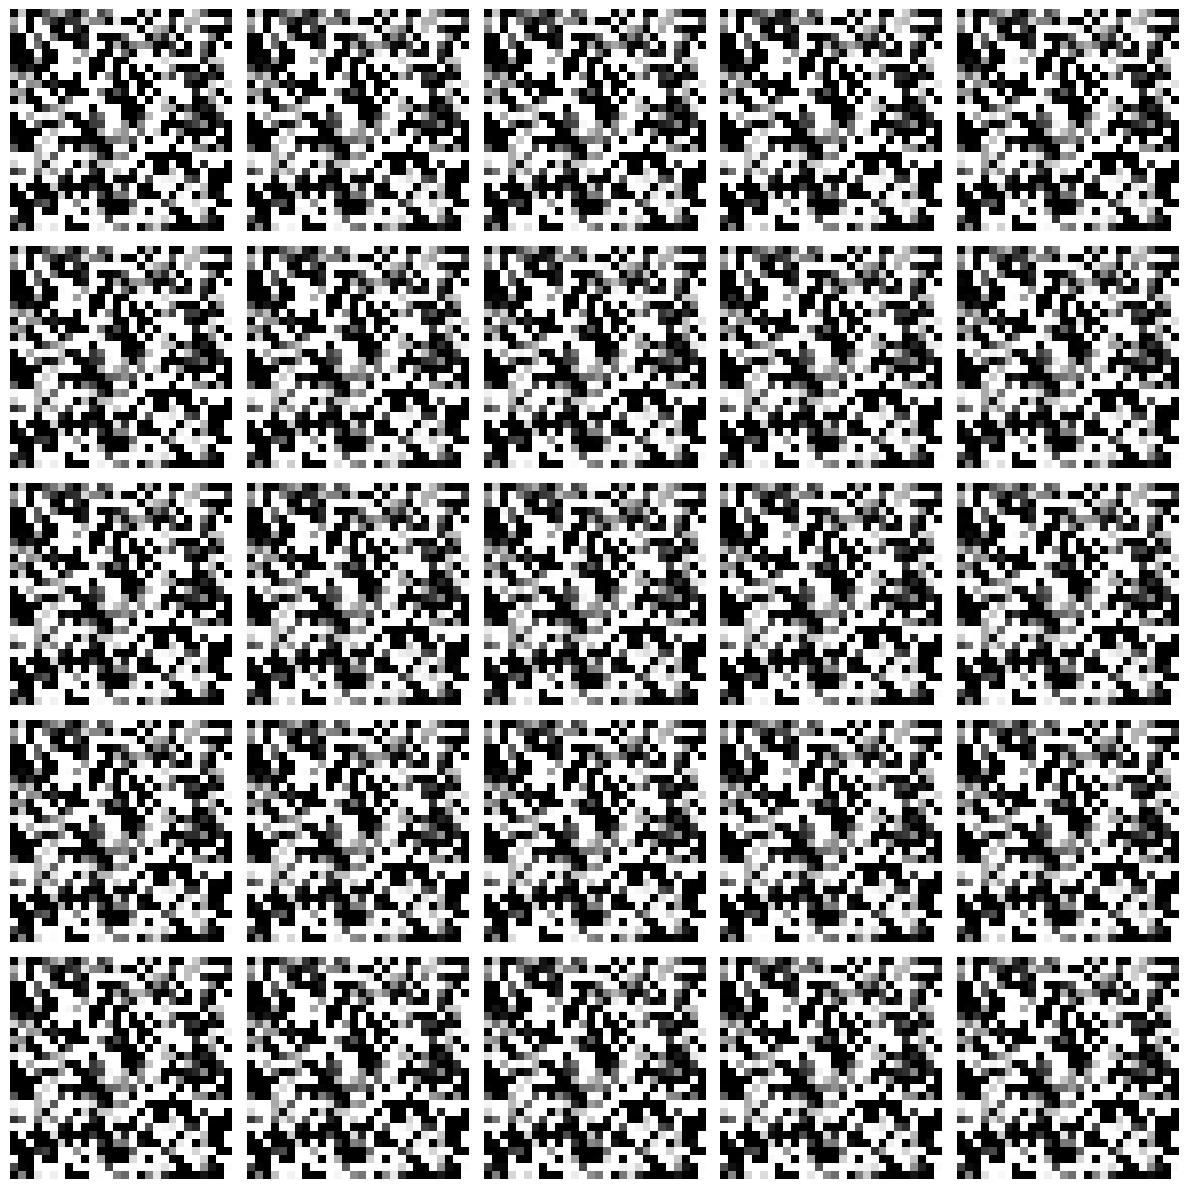

In [17]:
# Генерация противоречивых примеров с использованием обученного генератора
def generate_and_visualize_adversarial_samples(generator_model, num_samples=100):
    random_noise = np.random.normal(0, 1, (num_samples, 100))
    # Создание изображений с помощью генератора
    adversarial_images = generator_model.predict(random_noise)

    # Визуализация некоторых сгенерированных изображений
    plt.figure(figsize=(12, 12))
    for i in range(25):  # Вывод первых 25 изображений
        plt.subplot(5, 5, i + 1)
        plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return adversarial_images

# Генерация и визуализация
adversarial_samples = generate_and_visualize_adversarial_samples(generator_model, num_samples=100)


Шаг 3: Оценка моделей на противоречивых примерах

In [20]:
# Загрузка заранее обученных моделей
def load_pretrained_models(model_paths):
    models = []
    for path in model_paths:
        try:
            model = tf.keras.models.load_model(path)
            # Компиляция модели
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            models.append(model)
        except Exception as e:
            print(f"Ошибка при загрузке модели из {path}: {e}")
    return models

# Оценка моделей на противоречивых примерах с выводом потерь
def evaluate_models_on_adversarial_examples(models, adversarial_images):
    reshaped_adv_images = adversarial_images.reshape(-1, 28, 28, 1)
    labels_placeholder = np.ones((reshaped_adv_images.shape[0], 10))  # Заглушка для меток

    print(f"{'Модель':<10}{'Потери (Loss)':<15}{'Точность (Accuracy)':<15}")
    print("-" * 40)

    for i, model in enumerate(models):
        loss, accuracy = model.evaluate(reshaped_adv_images, labels_placeholder, verbose=0)
        print(f"{i + 1:<10}{loss:<15.4f}{accuracy:<15.4f}")

# Пути к заранее обученным моделям
model_paths = ['/content/mnist_model1.h5', '/content/mnist_model2.h5']

# Загрузка моделей
pretrained_models = load_pretrained_models(model_paths)

# Оценка на противоречивых примерах
evaluate_models_on_adversarial_examples(pretrained_models, adversarial_samples)



Модель    Потери (Loss)  Точность (Accuracy)
----------------------------------------
1         151.4522       0.0000         
2         741.1083       0.0000         


Вывод:

GAN успешно сгенерировал противоречивые примеры, которые полностью нейтрализовали точность предварительно обученных моделей (0.0%). Высокие потери обеих моделей подтверждают их уязвимость. Для повышения устойчивости требуется внедрение методов защиты.







